In [1]:
# prompt: truy cập google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from statistics import mean
import joblib



import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/dataset/Cycling_data/Raw_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/drive/MyDrive/dataset/Cycling_data/Raw_data/Active 2024_11_27_10_4_25.txt


In [3]:
from pathlib import Path
work_dir = Path('/content/drive/MyDrive/dataset/Cycling_data')

In [4]:
try:
    os.mkdir(work_dir/'figures')
    os.mkdir(work_dir/'models')
    os.mkdir(work_dir/'saved_objects')
except:
    print("Already have directory!")

Already have directory!


In [5]:
# LOAD DATA
raw_data = pd.read_csv(r'/content/drive/MyDrive/dataset/Cycling_data/cyclingLabel.csv')

# **1.Preview data**



In [6]:
# DISCOVER THE DATA TO GAIN INSIGHTS

# Quick view of the data
print('\n____________ Dataset info ____________')
print(raw_data.info())
print('\n____________ Some first data examples ____________')
print(raw_data.head(3))
print('\n____________ Statistics of numeric features ____________')
print(raw_data.describe())


____________ Dataset info ____________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136 entries, 0 to 1135
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             1136 non-null   object 
 1   t                1136 non-null   float64
 2   Tau_Motor        1136 non-null   float64
 3   Tau_1            1136 non-null   float64
 4   Tau_2            1136 non-null   float64
 5   vel              1136 non-null   float64
 6   encoder_count    1136 non-null   int64  
 7   mode             1136 non-null   object 
 8   level            1136 non-null   int64  
 9   turn             1136 non-null   int64  
 10  period           1136 non-null   int64  
 11  push_leg         1136 non-null   object 
 12  degree           1136 non-null   float64
 13  phase            1136 non-null   int64  
 14  Tau_Motor_deriv  1136 non-null   float64
 15  Tau_1_deriv      1136 non-null   float64
 16  Tau_2_deriv      113

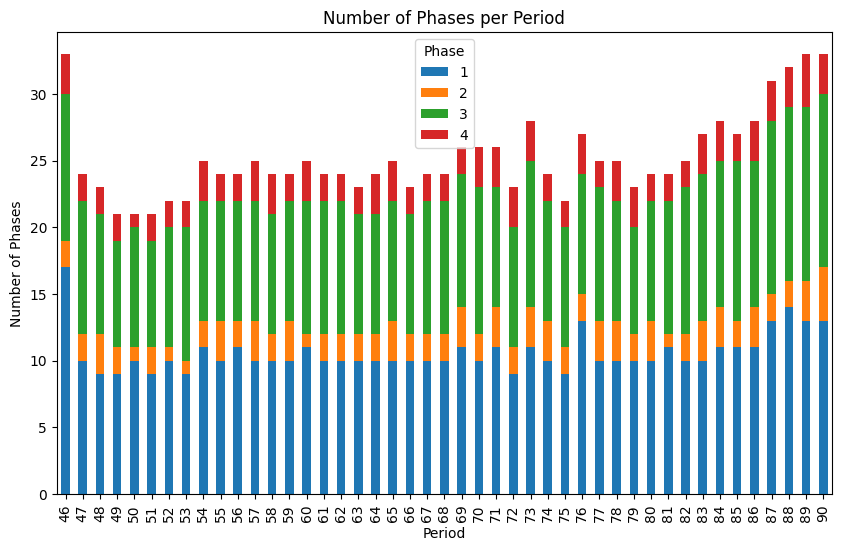

In [7]:
# prompt: từ raw data, vẽ biểu đồ số phase trên period

import matplotlib.pyplot as plt

# Group data by 'period' and count the occurrences of each phase
phase_counts = raw_data.groupby('period')['phase'].value_counts().unstack()

# Plot the number of phases per period
phase_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Period')
plt.ylabel('Number of Phases')
plt.title('Number of Phases per Period')
plt.legend(title='Phase')
plt.show()

# Lấy 1 period quan sát

In [8]:
period = 50

view_data = raw_data[raw_data["period"] == period]
# view_data = raw_data[(raw_data["period"] == period) | (raw_data["period"] == period+1)]
# Quick view of the data
print('\n____________ Some first data examples ____________')
print(view_data.head(3))
print('\n____________ Some last data examples ____________')
print(view_data.tail(3))
print('\n____________ Statistics of numeric features ____________')
print(view_data.describe())

# # Specify the path and name of the file
# file_path = work_dir/"figures/turn {0}/turn_{0}_{1}_Level_{2}.txt".format(turn,view_data['mode'].iloc[0],view_data['level'].iloc[0])
# print(file_path)
# # Open the file in write mode and write the text
# with open(file_path, "w") as file:
#     file.write("turn {}, mode {}, level {}.".format(turn,view_data['mode'].iloc[0],view_data['level'].iloc[0]))



____________ Some first data examples ____________
                     date       t  Tau_Motor  Tau_1  Tau_2    vel  \
101  10:4:25 - 27/11/2024  15.664       3.48  28.84  13.21  31.89   
102  10:4:25 - 27/11/2024  15.781       3.48  28.74  13.81  29.67   
103  10:4:25 - 27/11/2024  15.941       3.47  28.74  13.81  25.24   

     encoder_count    mode  level  turn  period push_leg     degree  phase  \
101           9800  Active      1    11      50        R   0.000000      1   
102           9930  Active      1    11      50        R  19.881054      1   
103          10078  Active      1    11      50        R  42.514868      1   

     Tau_Motor_deriv  Tau_1_deriv  Tau_2_deriv  vel_deriv  
101           -0.008    -0.055833     0.317500     -0.420  
102           -0.003    -0.058333     0.350000     -3.325  
103           -0.003     0.034167    -0.205833     -3.600  

____________ Some last data examples ____________
                     date       t  Tau_Motor  Tau_1  Tau_2    vel  


____________ Phase Counts for Period 50 ____________
phase
1    10
3     9
2     1
4     1
Name: count, dtype: int64


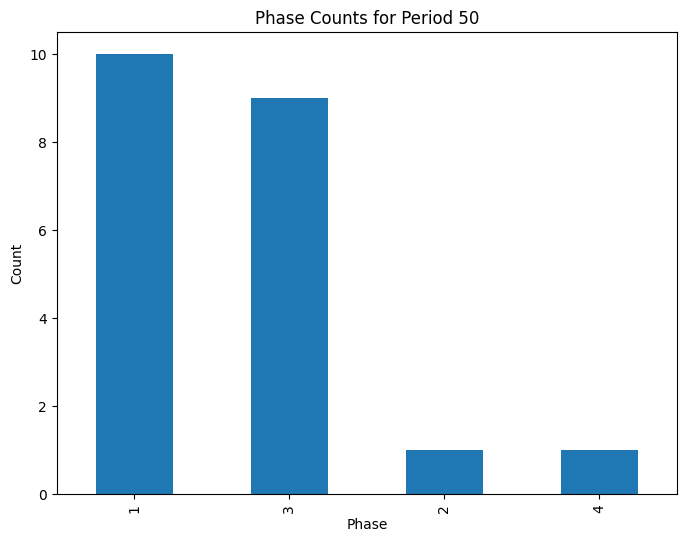

In [9]:
# prompt: từ view_data, thống kê số phase

# Count the occurrences of each phase in view_data
phase_counts_view = view_data['phase'].value_counts()

# Print the phase counts
print("\n____________ Phase Counts for Period {} ____________".format(period))
print(phase_counts_view)

# Plot the phase counts for the specific period
phase_counts_view.plot(kind='bar', figsize=(8, 6))
plt.xlabel('Phase')
plt.ylabel('Count')
plt.title('Phase Counts for Period {}'.format(period))
plt.show()

# **1.1. Statistic**




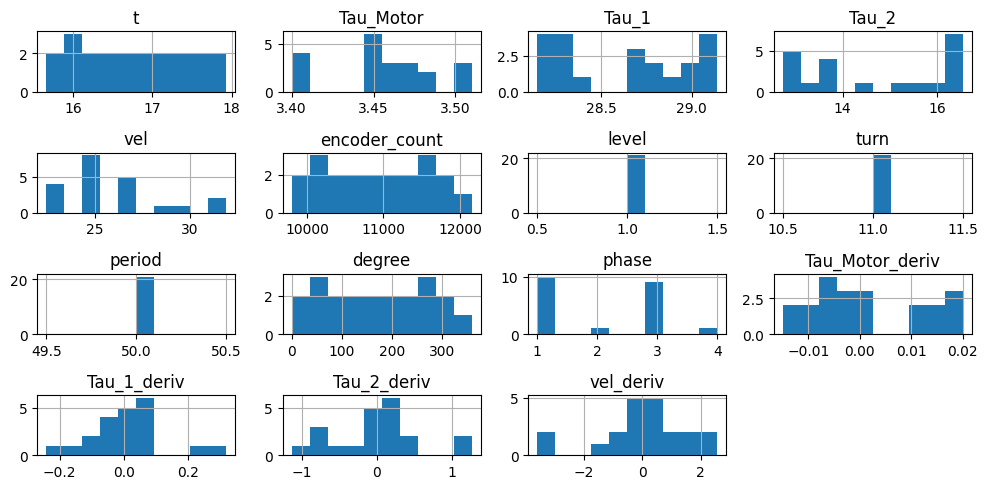

In [10]:
view_data.hist(figsize=(10,5)) #bins: no. of intervals
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.tight_layout()
# plt.savefig(work_dir/'figures/turn {}/hist_raw_data.png'.format(turn), format='png', dpi=300) # must save before show()
# plt.show()

In [11]:
def moving_average(x, w):
    """
    Average filter for reduce noise

    Args:
        x: Input array
        w: window size

    Returns:
        Filter array
    """
    return np.convolve(x, np.ones(w), 'same') / w

## Tổng quan data

In [12]:
view_data

,date,t,Tau_Motor,Tau_1,Tau_2,vel,encoder_count,mode,level,turn,period,push_leg,degree,phase,Tau_Motor_deriv,Tau_1_deriv,Tau_2_deriv,vel_deriv
101,10:4:25 - 27/11/2024,15.664,3.48,28.84,13.21,31.89,9800,Active,1,11,50,R,0.000000,1,-8.000000e-03,-0.055833,0.317500,-4.200000e-01
102,10:4:25 - 27/11/2024,15.781,3.48,28.74,13.81,29.67,9930,Active,1,11,50,R,19.881054,1,-3.000000e-03,-0.058333,0.350000,-3.325000e+00
103,10:4:25 - 27/11/2024,15.941,3.47,28.74,13.81,25.24,10078,Active,1,11,50,R,42.514868,1,-3.000000e-03,0.034167,-0.205833,-3.600000e+00
104,10:4:25 - 27/11/2024,16.023,3.47,28.74,13.81,22.47,10152,Active,1,11,50,R,53.831776,1,-6.000000e-03,-0.170833,1.063333,-1.340000e+00
105,10:4:25 - 27/11/2024,16.105,3.47,28.43,15.68,22.56,10225,Active,1,11,50,R,64.995752,1,-6.000000e-03,-0.241667,1.262500,1.550000e-01
106,10:4:25 - 27/11/2024,16.233,3.45,28.31,16.01,22.78,10344,Active,1,11,50,R,83.194562,1,-6.000000e-03,-0.104167,0.165833,1.100000e-01
107,10:4:25 - 27/11/2024,16.308,3.45,28.20,16.26,22.78,10418,Active,1,11,50,R,94.511470,1,-4.000000e-03,-0.084167,0.227500,1.130000e+00
108,10:4:25 - 27/11/2024,16.427,3.45,28.15,16.46,25.04,10545,Active,1,11,50,R,113.933730,1,1.110223e-15,-0.019167,0.148333,2.055000e+00
109,10:4:25 - 27/11/2024,16.561,3.45,28.16,16.55,26.89,10688,Active,1,11,50,R,135.802889,1,1.110223e-15,0.036667,0.038333,7.000000e-01
110,10:4:25 - 27/11/2024,16.631,3.45,28.22,16.55,26.44,10762,Active,1,11,50,R,147.119796,1,-1.000000e-02,0.092500,-0.025000,-1.900000e-01


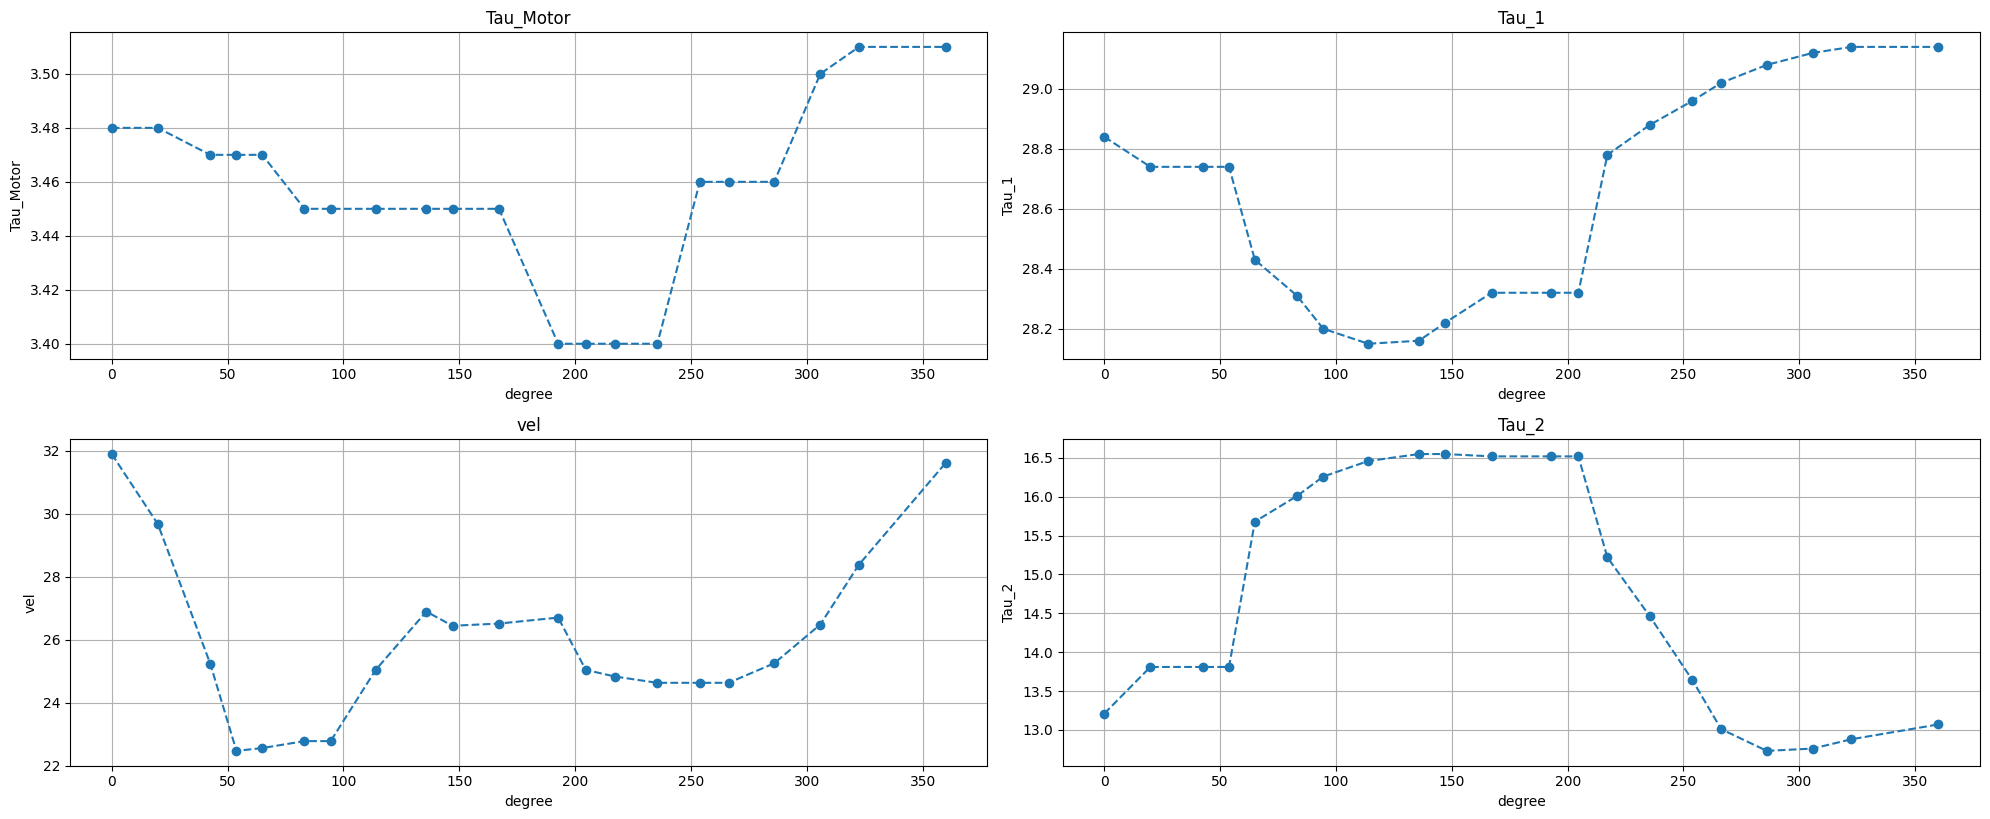

In [13]:
columns_to_plot = ['Tau_Motor', 'Tau_1', 'vel', 'Tau_2']

# Create a plot for each specified column with 't' as the x-axis
plt.figure(figsize=(20, 16))  # Adjust the figure size as needed

for i, col in enumerate(columns_to_plot, start=1):
    plt.subplot(4, 2, i)  # Creates a 4x2 grid for subplots, adjust if you have a different number of columns
    plt.plot(view_data['degree'], view_data[col], label=col, marker='o', linestyle='--')
    plt.xlabel('degree')
    plt.ylabel(col)
    plt.title(f'{col}')
    plt.grid(True)
plt.tight_layout()  # Adjust layout to avoid overlapping plots
# plt.savefig(work_dir/'figures/turn {}/view_data.png'.format(turn), format='png', dpi=300) # must save before show()
plt.show()

# 1.2. Scatter plot b/w every pair of features



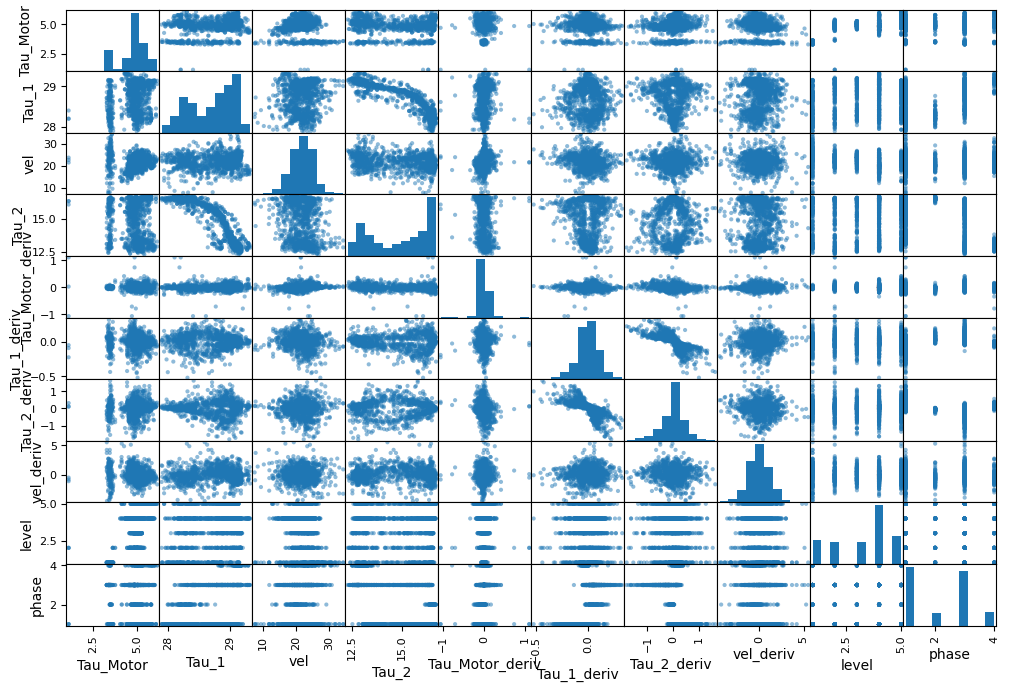

In [14]:
from pandas.plotting import scatter_matrix
features_to_plot = ['Tau_Motor', 'Tau_1', 'vel', 'Tau_2', 'Tau_Motor_deriv', 'Tau_1_deriv', 'Tau_2_deriv', 'vel_deriv', 'level', 'phase']
scatter_matrix(raw_data[features_to_plot], figsize=(12, 8)) # Note: histograms on the main diagonal
plt.savefig(work_dir/'figures/scatter_mat_all_feat.png', format='png', dpi=500)
plt.show()

# 1.3. Compute correlations b/w features

<Axes: >

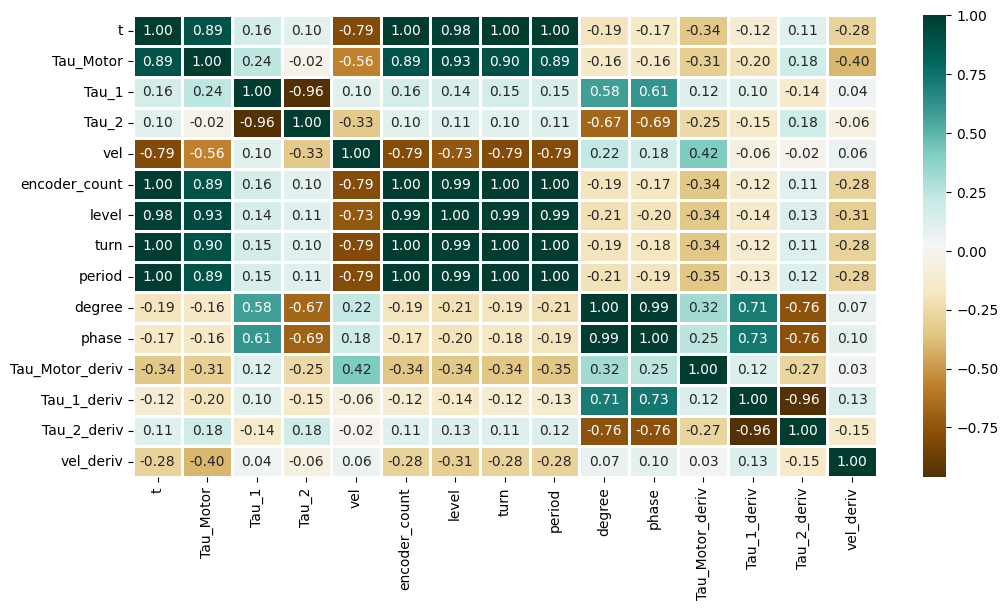

In [15]:
import seaborn as sns
corr_matrix = raw_data.corr(numeric_only=True)
plt.figure(figsize=(12, 6))
# Default corr() using Pearson for calculating linear correlation matrix
sns.heatmap(corr_matrix.corr(), cmap="BrBG", fmt=".2f", linewidths=2, annot=True)

# **2.PREPARE THE DATA**

# 2.1. Remove unused features

In [16]:
raw_data.drop(columns = ["date", "t", "encoder_count", "level", "period", "degree", "turn", "push_leg", "mode"], inplace=True)

In [17]:
print('\n____________ Dataset info ____________')
print(raw_data.info())


____________ Dataset info ____________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136 entries, 0 to 1135
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Tau_Motor        1136 non-null   float64
 1   Tau_1            1136 non-null   float64
 2   Tau_2            1136 non-null   float64
 3   vel              1136 non-null   float64
 4   phase            1136 non-null   int64  
 5   Tau_Motor_deriv  1136 non-null   float64
 6   Tau_1_deriv      1136 non-null   float64
 7   Tau_2_deriv      1136 non-null   float64
 8   vel_deriv        1136 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 80.0 KB
None


In [18]:
raw_data.isnull().sum()

,0
Tau_Motor,0
Tau_1,0
Tau_2,0
vel,0
phase,0
Tau_Motor_deriv,0
Tau_1_deriv,0
Tau_2_deriv,0
vel_deriv,0


In [19]:
raw_data.duplicated().sum()

0

# 2.2. Split training-test set


In [20]:
# prompt: scaler = MinMaxScaler()
# Từ raw_data, chuẩn hóa các cột dữ liệu trừ cột label "phase"

from sklearn.preprocessing import MinMaxScaler

# Assuming 'raw_data' is your DataFrame and it's already loaded
# from the previous code.

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Select columns to scale (exclude 'phase')
columns_to_scale = [col for col in raw_data.columns if col != 'phase']

# Fit and transform the selected columns
scaled_data = scaler.fit_transform(raw_data[columns_to_scale])

# Create a new DataFrame with scaled data
scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)

# Concatenate the scaled data with the 'phase' column
scaled_df['phase'] = raw_data['phase']

# Now 'scaled_df' contains the scaled data, and you can use it
# for your modeling.
print(scaled_df.head(6))

   Tau_Motor     Tau_1     Tau_2       vel  Tau_Motor_deriv  Tau_1_deriv  \
0   0.464789  0.576389  0.485393  0.011261         0.535304     0.555154   
1   0.464789  0.562500  0.519101  0.159910         0.522824     0.573098   
2   0.498994  0.513889  0.561798  0.328078         0.510345     0.573515   
3   0.494970  0.513889  0.561798  0.328078         0.502529     0.570594   
4   0.494970  0.458333  0.694382  0.276276         0.487816     0.516066   
5   0.494970  0.409722  0.761798  0.164414         0.468506     0.532619   

   Tau_2_deriv  vel_deriv  phase  
0     0.643707   0.818227      1  
1     0.552249   0.870305      1  
2     0.540908   0.672008      1  
3     0.614955   0.378568      1  
4     0.672008   0.229344      1  
5     0.600146   0.174261      1  


In [21]:
# prompt: dùng one hot encoder cho label gán vào y list

from sklearn.preprocessing import OneHotEncoder

# Assuming 'scaled_df' is your DataFrame with the 'phase' column
# Create a OneHotEncoder object
enc = OneHotEncoder(handle_unknown='ignore')

# Fit the encoder on the 'phase' column
enc.fit(scaled_df[['phase']])

# Transform the 'phase' column into one-hot encoded features
y = enc.transform(scaled_df[['phase']]).toarray()


print(y[10:40])

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [22]:
from sklearn.preprocessing import OneHotEncoder
def split_sequence_xy(df, label, window_size):
  x = []
  y = []
  enc = OneHotEncoder(handle_unknown='ignore')
  enc.fit(scaled_df[[label]])
  y = enc.transform(scaled_df[[label]]).toarray()[window_size:]
  for i in range(window_size, len(df)):
    sequence = df.iloc[i-window_size:i].drop(columns=label).values
    x.append(sequence)

  return np.array(x), y

def split_xy(df, label):
  x = []
  y = []
  enc = OneHotEncoder(handle_unknown='ignore')
  enc.fit(scaled_df[[label]])
  y = enc.transform(scaled_df[[label]]).toarray()
  x = df.drop(columns=label).values

  return np.array(x), y

### Train HMM

In [50]:
X,y = split_xy(scaled_df, label = "phase")
print(len(X),len(y))

1136 1136


In [51]:
print(X[0])
print(y[0])

[0.46478873 0.57638889 0.48539326 0.01126126 0.53530378 0.55515371
 0.64370686 0.81822734]
[1. 0. 0. 0.]


In [24]:
from pprint import pprint # dùng cho mục đích in "đẹp"
from collections import defaultdict # để đếm số lượng lần xảy ra của các trạng thái (đơn lẻ và cặp)

In [25]:
data = raw_data.phase.to_list()

In [26]:
# tạo nơi lưu trữ giá trị
phase_count = defaultdict(int)
phase_pair_count = defaultdict(lambda: defaultdict(float))

In [27]:
# food_count: đếm số lần xuất hiện của một trạng thái
# food_pair_count: đếm tất cả các cặp trạng thái có thể [current][future]
n = len(data)
for i in range(n):
    phase_count[data[i]] += 1
    if i == n - 1:
        phase_pair_count[data[i]][data[i]] += 1
        break
    phase_pair_count[data[i]][data[i + 1]] += 1

In [28]:
# chuẩn hóa theo tổng hàng
for key, value in phase_pair_count.items():
    for k, v in value.items():
        phase_pair_count[key][k] /= phase_count[key] # chuẩn hóa

In [29]:
# lấy index của các món ăn để dễ thao tác
keys = list(phase_count.keys())
idx = range(len(keys))
key_to_idx = dict(zip(keys, idx)) # key to index
print(key_to_idx)

{1: 0, 2: 1, 3: 2, 4: 3}


In [30]:
P = []
for key, value in phase_pair_count.items():
    P.append(list(value.values()))

# chuyển list sang numpy để dễ tính toán
P = np.array(P)

print('Ma trận chuyển trạng thái P: ')
pprint(P)

Ma trận chuyển trạng thái P: 
array([[0.90566038, 0.09433962],
       [0.5631068 , 0.4368932 ],
       [0.8988764 , 0.1011236 ],
       [0.6036036 , 0.3963964 ]])


In [31]:
# tổng hàng của ma trận phải luôn bằng 1
print(P.sum(axis=1))

[1. 1. 1. 1.]


In [45]:

P = np.array([[0.90566038, 0.09433962,       0.0,       0.0],
              [       0.0,  0.5631068, 0.4368932,       0.0],
              [       0.0,        0.0, 0.8988764, 0.1011236],
              [ 0.3963964,        0.0,       0.0, 0.6036036]])

In [46]:
# dự đoán món ăn
curr_phase = data[10]
next_phase = data[11]
curr_distribution = P[key_to_idx[curr_phase]]
predicted_phase = np.random.choice(keys, p=curr_distribution) # random walk with known distribution
predicted_probability = P[key_to_idx[curr_phase]][key_to_idx[predicted_phase]]

In [47]:
print(f'Current phase: {curr_phase}')
print(f'Predict next phase: "{predicted_phase}"\
 with probalility of {round(predicted_probability * 100, 2)}%')
print(f'True next phase: {next_phase}')

Current phase: 1
Predict next phase: "1" with probalility of 90.57%
True next phase: 1


In [48]:
predicted_phases = np.ones(len(data[:-1]))
true_phases = np.ones(len(data[1:]))
for i in range(len(data[:-1])):
  curr_phase = data[i]
  true_phases[i] = data[i+1]
  curr_distribution = P[key_to_idx[curr_phase]]
  predicted_phases[i] = np.random.choice(keys, p=curr_distribution) # random walk with known distribution

Accuracy of HMM model: 0.7577092511013216


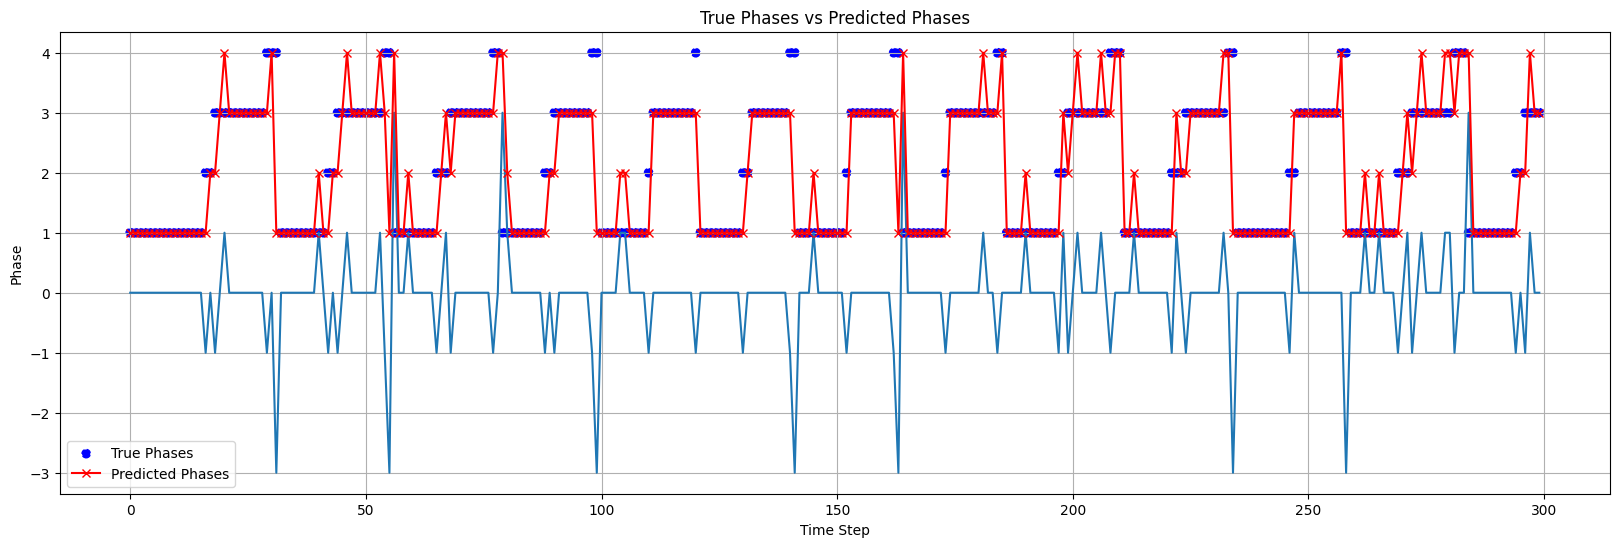

In [49]:
# prompt: viết code tính acc model hmm

# Assuming X_test and y_test are defined as in your provided code.
# X_test: Test features
# y_test: One-hot encoded test labels

# Convert one-hot encoded y_test back to class labels for comparison
import numpy as np


# Calculate the difference
diff = predicted_phases - true_phases
a = 0
b = 300

# Calculate the accuracy
accuracy = np.mean(predicted_phases == true_phases)
print(f"Accuracy of HMM model: {accuracy}")
# Step 4: Visualization
def plot_phases(true_phases, predicted_phases):
    plt.figure(figsize=(20, 6))
    x = np.arange(len(true_phases[a:b]))

    plt.plot(diff[a:b])
    plt.scatter(x, true_phases[a:b], marker='o', label="True Phases", linestyle="--", color="blue")
    plt.plot(predicted_phases[a:b], marker='x', label="Predicted Phases", linestyle="-", color="red")

    plt.title("True Phases vs Predicted Phases")
    plt.xlabel("Time Step")
    plt.ylabel("Phase")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_phases(true_phases, predicted_phases)

In [ ]:
predicted_phases[30:200]

### Train ANN

In [52]:
# prompt: từ tập x,y, chia train, validation, test set theo tỉ lệ  80%:10%:10%

from sklearn.model_selection import train_test_split

X_for_train = X[:int(0.8*len(X))]
X_for_test = X[int(0.8*len(X)):]
y_for_train = y[:int(0.8*len(y))]
y_for_test = y[int(0.8*len(y)):]
# Assuming X and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X_for_train, y_for_train, test_size=0.2, random_state=42)  # 80% train, 20% temp

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 726
Testing set size: 182


In [53]:
print(X_train.shape)
print(y_train[0])

(726, 8)
[1. 0. 0. 0.]


In [ ]:
# prompt: Tạo class weight từ data train đã one-hot

import numpy as np

# Assuming y_train is your one-hot encoded training labels
# Calculate class weights based on the number of samples in each class
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
class_weights = dict(zip(unique, counts))

# Normalize the class weights
total_samples = np.sum(counts)
class_weights = {k: v / total_samples for k, v in class_weights.items()}

print(f"Class weights: {class_weights}")

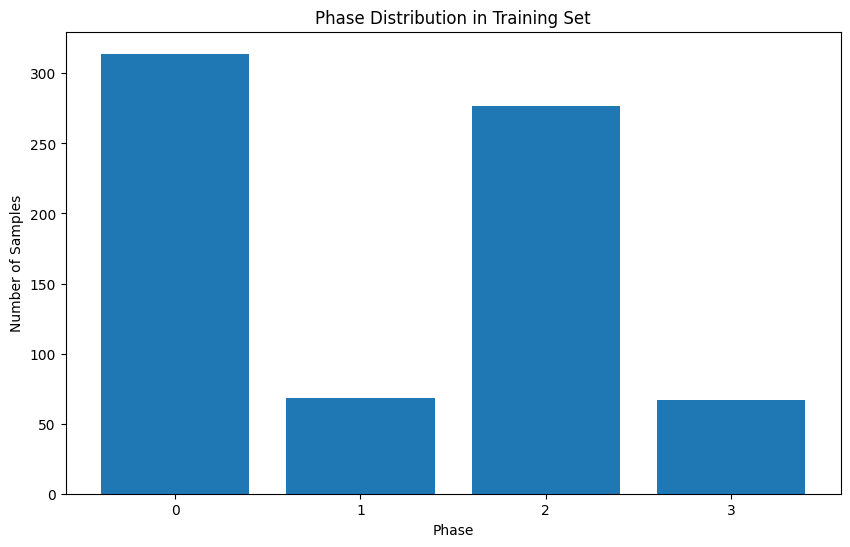

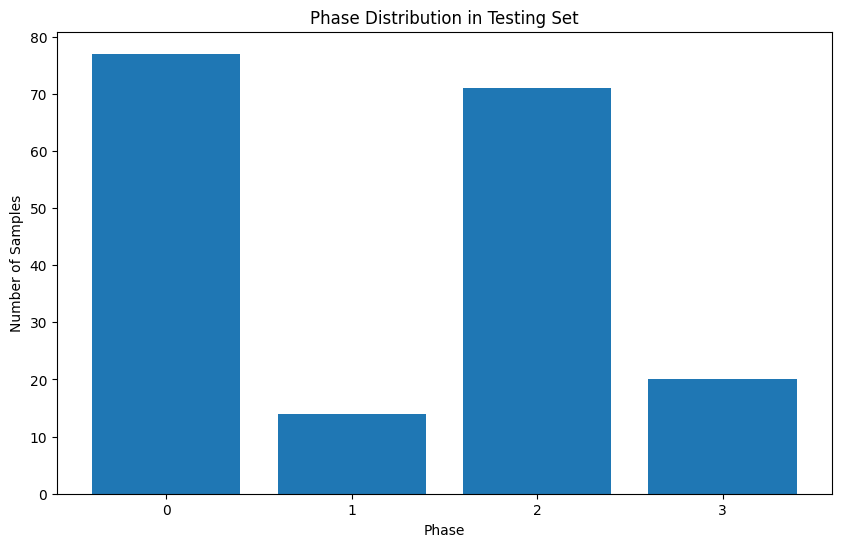

In [54]:
# prompt: từ y train, y test, vẽ biểu đồ phase/ sample

import matplotlib.pyplot as plt

# Assuming y_train and y_test are numpy arrays where each row represents a sample
# and each column represents a class (one-hot encoded).

def plot_phase_samples(y_data, title):
    """Plots the distribution of phases/samples."""
    num_samples = len(y_data)
    num_classes = y_data.shape[1]  # Assuming one-hot encoding

    phase_counts = np.sum(y_data, axis=0)  # Sum across samples for each class

    plt.figure(figsize=(10, 6))
    plt.bar(range(num_classes), phase_counts)
    plt.xlabel("Phase")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.xticks(range(num_classes))  # Ensure all class labels are displayed
    plt.show()

plot_phase_samples(y_train, "Phase Distribution in Training Set")
plot_phase_samples(y_test, "Phase Distribution in Testing Set")

# **3.TRAIN AND EVALUATE MODELS**

In [55]:
# prompt: dùng kares, viết các function tạo các model RNN, GRU, LSTM với các thông số điều chỉnh cơ bản để sử dụng (input, output, layer,...)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2
def create_ann_model(input_shape, num_classes, hidden_layers, activation='relu', dropout_rate=0, regularization=None, regularization_rate=0.01):
    """
    Creates an Artificial Neural Network (ANN) model using Keras.

    Args:
        input_shape (tuple): Shape of the input data.
        num_classes (int): Number of output classes.
        hidden_layers (list): A list of integers representing the number of neurons in each hidden layer.
        activation (str): Activation function for hidden layers (default: 'relu').

    Returns:
        keras.Model: ANN model.
    """
    model = keras.Sequential()
    model.add(keras.Input(shape=input_shape))

    for units in hidden_layers:
      #Regularization
      if regularization == 'l1':
        reg = l1(regularization_rate)
      elif regularization == 'l2':
        reg = l2(regularization_rate)
      else:
        reg = None
      model.add(Dense(units, activation=activation))
      if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    model.add(Dense(num_classes, activation='softmax')) # Output layer with softmax for multi-class classification
    return model

def create_rnn_model(input_shape, output_dim, num_layers=1, units=64, dropout_rate=0, regularization=None, regularization_rate=0.01):
  model = keras.Sequential()
  for _ in range(num_layers):
    #Regularization
    if regularization == 'l1':
      reg = l1(regularization_rate)
    elif regularization == 'l2':
      reg = l2(regularization_rate)
    else:
      reg = None
    model.add(SimpleRNN(units, activation='relu', return_sequences=True if _ < num_layers -1 else False, input_shape=input_shape, kernel_regularizer=reg))
    if dropout_rate > 0:
      model.add(Dropout(dropout_rate))
  model.add(Dense(output_dim, activation='softmax'))  # Adjust activation based on your task
  return model

def create_gru_model(input_shape, output_dim, num_layers=1, units=64, dropout_rate=0, regularization=None, regularization_rate=0.01):
  model = keras.Sequential()
  for i in range(num_layers):
    #Regularization
    if regularization == 'l1':
      reg = l1(regularization_rate)
    elif regularization == 'l2':
      reg = l2(regularization_rate)
    else:
      reg = None

    model.add(GRU(units, activation='relu', return_sequences=True if i < num_layers - 1 else False, input_shape=input_shape, kernel_regularizer=reg))
    if dropout_rate > 0:
      model.add(Dropout(dropout_rate))
  model.add(Dense(output_dim, activation='softmax'))  # Adjust activation based on your task
  return model


def create_lstm_model(input_shape, output_dim, num_layers=1, units=64, dropout_rate=0, regularization=None, regularization_rate=0.01):
  model = keras.Sequential()
  for _ in range(num_layers):
    #Regularization
    if regularization == 'l1':
      reg = l1(regularization_rate)
    elif regularization == 'l2':
      reg = l2(regularization_rate)
    else:
      reg = None
    model.add(LSTM(units, activation='relu', return_sequences=True if _ < num_layers - 1 else False, input_shape=input_shape, kernel_regularizer=reg))
    if dropout_rate > 0:
      model.add(Dropout(dropout_rate))
  model.add(Dense(output_dim, activation='softmax'))  # Adjust activation based on your task
  return model

In [60]:
model = create_ann_model(input_shape=(X_train.shape[1],), num_classes=4, hidden_layers=[64,64], dropout_rate=0.2, regularization= None, regularization_rate=0.005)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,996 (19.52 KB)

 Trainable params: 4,996 (19.52 KB)

 Non-trainable params: 0 (0.00 B)

## Compile and fit model

In [61]:
learning_rate = 6e-4
batch_size = 128
epochs = 100

print("Compile model ...")

model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[
            keras.metrics.CategoricalAccuracy(),
            keras.metrics.TruePositives(),
            keras.metrics.FalseNegatives(),
            keras.metrics.Precision(),
            keras.metrics.F1Score(),
            keras.metrics.Recall(),
        ],
    )

# Định nghĩa callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

# Training the model
print("Training ...")
history = model.fit(
            x=X_train,
            y=y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose="auto",
            callbacks=[early_stop],
            validation_split=0.2,
            validation_data=None,
            shuffle=True,
            class_weight=None,
            sample_weight=None,
            initial_epoch=0,
            steps_per_epoch=None,
            validation_steps=None,
            validation_batch_size=None,
            validation_freq=1,
        )

Compile model ...
Training ...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - categorical_accuracy: 0.3783 - f1_score: 0.1532 - false_negatives_2: 406.6667 - loss: 1.4211 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives_2: 0.0000e+00 - val_categorical_accuracy: 0.3699 - val_f1_score: 0.1350 - val_false_negatives_2: 146.0000 - val_loss: 1.3736 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_true_positives_2: 0.0000e+00
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.3702 - f1_score: 0.1352 - false_negatives_2: 406.6667 - loss: 1.3684 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives_2: 0.0000e+00 - val_categorical_accuracy: 0.3699 - val_f1_score: 0.1350 - val_false_negatives_2: 146.0000 - val_loss: 1.3346 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_true_positives_2: 0.0000e+00
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.3724 - f1_score: 0.1357 - false_nega

## Evaluate model

Test Loss: 0.4758
Test Accuracy: 0.7967
Test True Positives: 119.0000
Test False Negatives: 63.0000
Test Precision: 0.9084
Test F1 Score: [0.8243243  0.5333333  0.87999994 0.5555555 ]
Test Recall: 0.6538
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


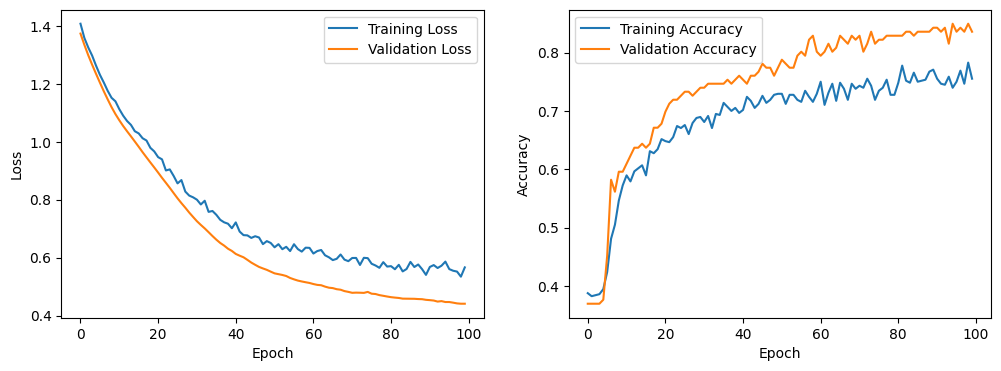

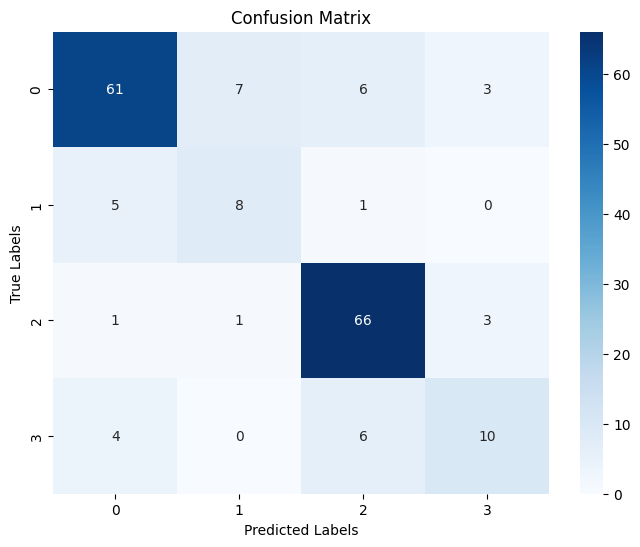

In [62]:
# prompt: sau khi train, vẽ các biểu đồ đánh giá cần thiết để quan sát, chú thích model dạng gì, dùng phương thức đánh giá nào

import matplotlib.pyplot as plt

# Evaluate the model
loss, accuracy, true_positives, false_negatives, precision, f1_score, recall = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test True Positives: {true_positives:.4f}")
print(f"Test False Negatives: {false_negatives:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test F1 Score: {f1_score}")
print(f"Test Recall: {recall:.4f}")

# Make predictions
y_pred = model.predict(X_test)

# Plot training history (assuming you have history object from model.fit)
# Assuming 'history' object is available from the model training
# Example: history = model.fit(...)
if 'history' in locals():  # Check if history exists
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
else:
    print("Training history not found. Please run model.fit() first.")


# Plot the confusion matrix (example)
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_classes = np.argmax(y_pred, axis=1)  # Assuming one-hot encoded labels
y_true_classes = np.argmax(y_test, axis=1)  # Assuming one-hot encoded labels


conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Model description:
# - Model type: SimpleRNN (or GRU/LSTM if used in the create_model function)
# - Number of layers: 1 (configurable in create_model function)
# - Units per layer: 64 (configurable in create_model function)
# - Input shape: (WINDOW_SIZE, number of features)
# - Activation functions: ReLU for RNN layers, softmax for output layer
# - Loss function: BinaryCrossentropy
# - Optimizer: Adam
# - Metrics: BinaryAccuracy and FalseNegatives


# Evaluation method:
# The model was evaluated using the test set (20% of the data)
# The following metrics were used:
# - Loss: BinaryCrossentropy loss
# - Accuracy: Binary accuracy
# - False Negatives: Number of false negative predictions
# - Confusion Matrix: A visual representation of the model's performance in classifying different classes

# Add more evaluation metrics as needed (precision, recall, F1-score, etc.)
# You can also visualize predicted vs. actual values for a more in-depth analysis

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


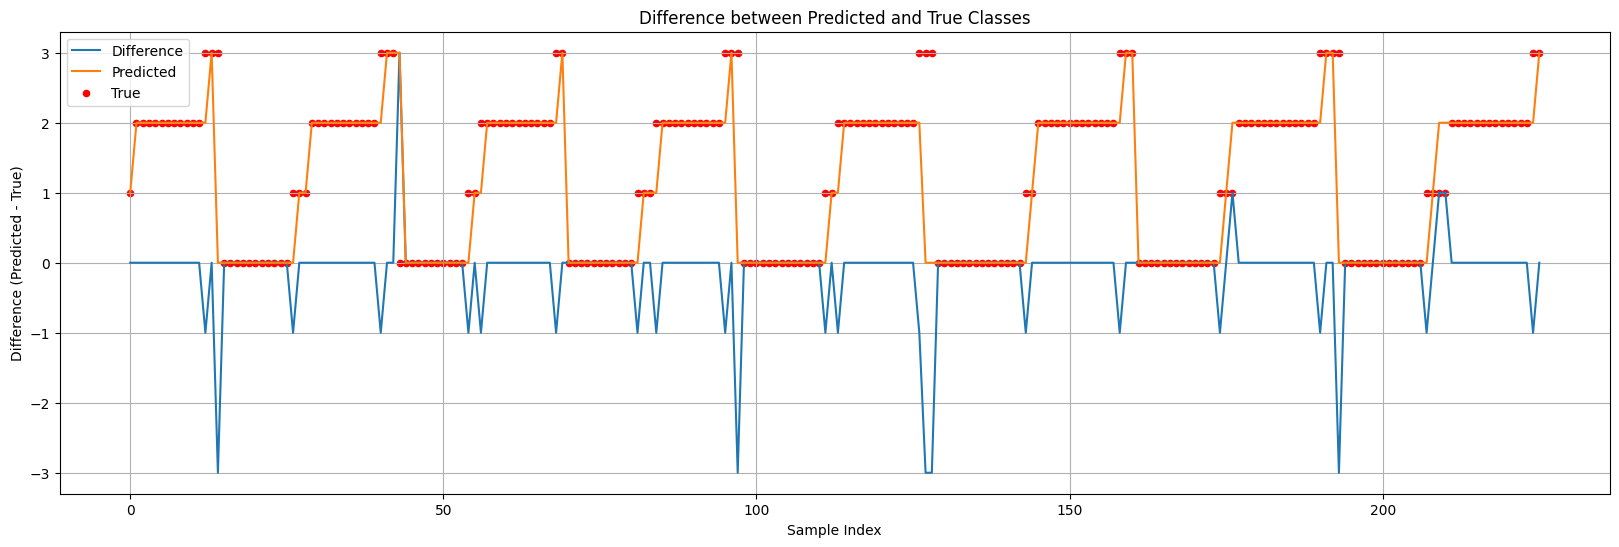

In [71]:
# prompt: tính y_pred_classes - y_trued_classes,vẽ biểu đồ đường

import matplotlib.pyplot as plt

# Assuming y_pred_classes and y_true_classes are already defined
# from your previous code.

# Make predictions
y_pred = model.predict(X_for_test[1:])
y_past_classes = np.argmax(y_for_test[:-1], axis=1)  # Assuming one-hot encoded labels
for i in range(len(y_past_classes)):
  y_pred[i] = y_pred[i]*P[y_past_classes[i]]
y_true = y_for_test[1:]

y_pred_classes = np.argmax(y_pred, axis=1)  # Assuming one-hot encoded labels
y_true_classes = np.argmax(y_true, axis=1)  # Assuming one-hot encoded labels


# Calculate the difference
diff = y_pred_classes - y_true_classes
a = 0
b = -1
# Create the line plot
plt.figure(figsize=(20, 6))
plt.plot(diff[a:b])
plt.plot(y_pred_classes[a:b])
plt.scatter(range(len(y_true_classes[a:b])), y_true_classes[a:b], color='red', label='True Classes', marker='o', s=20) # s is the marker size
plt.xlabel("Sample Index")
plt.ylabel("Difference (Predicted - True)")
plt.title("Difference between Predicted and True Classes")
plt.legend(["Difference", "Predicted", "True"])
plt.grid(True)
plt.show()

Accuracy: 0.8766519823788547
Precision: 0.8602266780838209
Recall: 0.718527731159594
F1 Score: 0.7580238225685922
True Positives: 10
False Negatives: 7


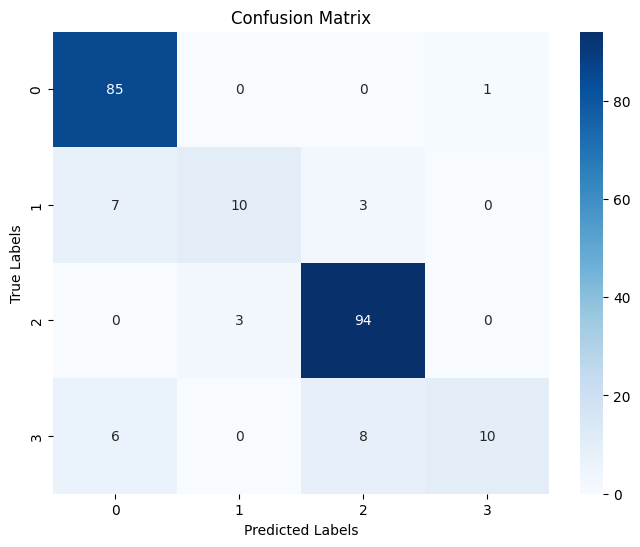

In [72]:
# prompt: y_pred_classes = np.argmax(y_pred, axis=1)  # Assuming one-hot encoded labels
# y_true_classes = np.argmax(y_true, axis=1)  # Assuming one-hot encoded labels
# tính accuracy, True Positives, False Negatives, Precision, F1 Score, Recall, lập confuse matrix

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, recall_score

# Assuming y_pred and y_true are defined as in your provided code.
# y_pred: Predicted probabilities (output of the model)
# y_true: True one-hot encoded labels

y_pred_classes = np.argmax(y_pred, axis=1)  # Assuming one-hot encoded labels
y_true_classes = np.argmax(y_true, axis=1)  # Assuming one-hot encoded labels

# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy}")

# Calculate True Positives, False Negatives, Precision, F1 Score, Recall
# Note: These metrics require you to specify the positive class label.
# If you have a multi-class problem, you'll need to compute these metrics per class or use averages (e.g., macro-average, micro-average)
# Example with macro average:

precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

true_positives = np.sum(np.logical_and(y_pred_classes == 1, y_true_classes == 1)) # Example for class 1
false_negatives = np.sum(np.logical_and(y_pred_classes == 0, y_true_classes == 1)) # Example for class 1


print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"True Positives: {true_positives}")
print(f"False Negatives: {false_negatives}")


# Create confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix (same code as before)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


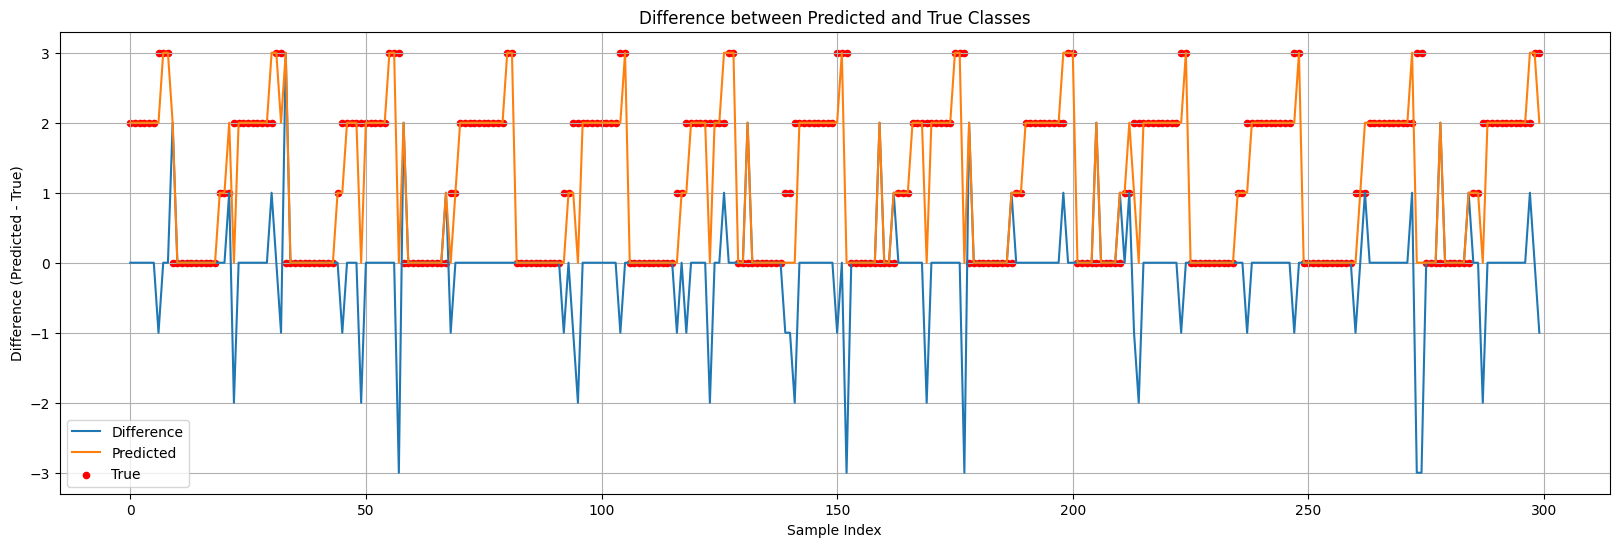

In [63]:
# prompt: tính y_pred_classes - y_trued_classes,vẽ biểu đồ đường

import matplotlib.pyplot as plt

# Assuming y_pred_classes and y_true_classes are already defined
# from your previous code.

# Make predictions
y_pred = model.predict(X)
y_pred_classes = np.argmax(y_pred, axis=1)  # Assuming one-hot encoded labels
y_true_classes = np.argmax(y, axis=1)  # Assuming one-hot encoded labels
# Calculate the difference
diff = y_pred_classes - y_true_classes
a = 300
b = 600
# Create the line plot
plt.figure(figsize=(20, 6))
plt.plot(diff[a:b])
plt.plot(y_pred_classes[a:b])
plt.scatter(range(len(y_true_classes[a:b])), y_true_classes[a:b], color='red', label='True Classes', marker='o', s=20) # s is the marker size
plt.xlabel("Sample Index")
plt.ylabel("Difference (Predicted - True)")
plt.title("Difference between Predicted and True Classes")
plt.legend(["Difference", "Predicted", "True"])
plt.grid(True)
plt.show()

In [ ]:
# prompt: y_pred[i] = y_pred[i]*P[y_past_classes[i]]
# viết lại hàm để nhân giá trị của y pred với giá trị tương ứng của P

y_pred = model.predict(X_for_test[1:])
y_past_classes = np.argmax(y_for_test[:-1], axis=1)  # Assuming one-hot encoded labels

# Multiply y_pred values with corresponding P values
for i in range(len(y_pred)):
    y_pred[i] = y_pred[i] * P[y_past_classes[i]]

In [ ]:
# prompt: lưu model hmm và RNN vào work_dir (theo ngày, giờ múi giờ Tp Hồ Chí Minh)

import pytz
from datetime import datetime

# ... (your existing code) ...

# Specify the timezone for Ho Chi Minh City
tz = pytz.timezone('Asia/Ho_Chi_Minh')

# Get the current time in Ho Chi Minh City
now = datetime.now(tz)
timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")

# Save HMM model
hmm_model_path = work_dir / f"models/hmm_model{timestamp}.pkl"
joblib.dump(model, hmm_model_path)

# Save RNN model
rnn_model_path = work_dir / f"models/rnn_model{timestamp}.h5"
model.save(rnn_model_path)

print(f"HMM model saved to: {hmm_model_path}")
print(f"RNN model saved to: {rnn_model_path}")

In [ ]:
# prompt: Thêm đánh giá trên từng phase xem chính xác bao nhiêu %

# ... (Your existing code)

# Assuming 'y_pred' contains your model's predictions and 'y_test' contains the true labels
# Both are assumed to be one-hot encoded

from sklearn.metrics import accuracy_score

# Calculate overall accuracy
overall_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")


# Calculate accuracy per phase
for i in range(y_test.shape[1]):  # Iterate over each phase
    # Get the true labels and predictions for the current phase
    y_true_phase = y_test[:, i]
    y_pred_phase = y_pred[:, i]

    # Apply a threshold to convert probabilities to binary predictions
    threshold = 0.5
    y_pred_binary_phase = (y_pred_phase >= threshold).astype(int)

    # Calculate accuracy for the current phase
    phase_accuracy = accuracy_score(y_true_phase, y_pred_binary_phase)

    # Print the accuracy for each phase
    print(f"Accuracy for Phase {i}: {phase_accuracy:.4f}")

# ... (Rest of your existing code)

# 4. Pipeline Fine-turn

In [ ]:
def turning_model_RNN_type(l_window, l_model_type, l_num_layers, l_units, l_drop_out, l_regularization, l_regularization_rate, l_learning_rate, l_batch_size, l_epochs, l_patience):
  result = []
  l_param = []
  WINDOW = 0
  turn = 0
  for window in l_window:
    for model_type in l_model_type:
      for num_layers in l_num_layers:
        for units in l_units:
          for dropout_rate in l_drop_out:
            for regularization in l_regularization:
              for regularization_rate in l_regularization_rate:
                for learning_rate in l_learning_rate:
                  for batch_size in l_batch_size:
                    for epochs in l_epochs:
                      for patience in l_patience:
                        l_param.append([turn,window, model_type, num_layers, units, dropout_rate, regularization, regularization_rate, learning_rate, batch_size, epochs, patience])
                        turn+=1
  print(f"Turning param {len(l_param)} turn!")
  for param in l_param:
    print(f"Turn {param[0]} ...")
    window = param[1]
    model_type = param[2]
    num_layers = param[3]
    units = param[4]
    dropout_rate = param[5]
    regularization = param[6]
    regularization_rate = param[7]
    learning_rate = param[8]
    batch_size = param[9]
    epochs = param[10]
    patience = param[11]
    print(f"Turning param:  window = {window}, model_type = {model_type}, num_layer = {num_layers}, units = {units}, dropout_rate = {dropout_rate}, regularization = {regularization}, regularization_rate = {regularization_rate}, learning_rate = {learning_rate}, batch_size = {batch_size}, epochs = {epochs}, patience = {patience}")

    # Split sequence, label
    print("Split sequence, label")
    if window != WINDOW:
      WINDOW = window
      X, y = split_sequence_xy(scaled_df, label = "phase", window_size=WINDOW)
      X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% temp
      unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
      class_weights = dict(zip(unique, counts))

      # Normalize the class weights
      total_samples = np.sum(counts)
      class_weights = {k: v / total_samples for k, v in class_weights.items()}

    # Startup model
    print("Startup model ...")
    if model_type == "rnn":
      model = create_rnn_model(input_shape=(X_train.shape[1],X_train.shape[2]), output_dim=4, num_layers=num_layers, units=units, dropout_rate=dropout_rate, regularization=regularization, regularization_rate=regularization_rate)
    elif model_type == "lstm":
      model = create_lstm_model(input_shape=(X_train.shape[1],X_train.shape[2]), output_dim=4, num_layers=num_layers, units=units, dropout_rate=dropout_rate, regularization=regularization, regularization_rate=regularization_rate)
    elif model_type == "gru":
      model = create_gru_model(input_shape=(X_train.shape[1],X_train.shape[2]), output_dim=4, num_layers=num_layers, units=units, dropout_rate=dropout_rate, regularization=regularization, regularization_rate=regularization_rate)

    # Setup training
    print("Setup training ...")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[
            keras.metrics.CategoricalAccuracy(),
            keras.metrics.FalseNegatives(),
            keras.metrics.Precision(),
        ],
    )
    # Định nghĩa callback
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min')
    print("Training ...")
    history = model.fit(
                x=X_train,
                y=y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose="auto",
                callbacks=[early_stop],
                validation_split=0.2,
                validation_data=None,
                shuffle=True,
                class_weight=class_weights,
                sample_weight=None,
                initial_epoch=0,
                steps_per_epoch=None,
                validation_steps=None,
                validation_batch_size=None,
                validation_freq=1,
            )
    # Evaluate the model
    loss, accuracy, false_negatives, precision = model.evaluate(X_test, y_test, verbose=0)
    result.append([param, loss, accuracy, false_negatives, precision, history, model])
  return result


In [ ]:
def turning_model_ANN_type(l_hidden_layers, l_learning_rate, l_batch_size, l_epochs):
  result = []
  # Split sequence, label
  print("Split label")
  X,y = split_xy(scaled_df, label = "phase")
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% temp
  l_param = []
  for hidden_layers in l_hidden_layers:
    for learning_rate in l_learning_rate:
      for batch_size in l_batch_size:
        for epochs in l_epochs:
          l_param.append([hidden_layers, learning_rate, batch_size, epochs])
  print(f"Turning param {len(l_param)} turn!")
  for param in l_param:
    hidden_layers = param[0]
    learning_rate = param[1]
    batch_size = param[2]
    epochs = param[3]
    print(f"Turning param:  hidden_layers = {hidden_layers}, learning_rate = {learning_rate}, batch_size = {batch_size}, epochs = {epochs}")
    # Startup model
    print("Startup model ...")
    model = create_ann_model(input_shape=(X_train.shape[1],), num_classes=6, hidden_layers=hidden_layers)

    # Setup training
    print("Setup training ...")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.FalseNegatives(),
        ],
    )
    print("Training ...")
    history = model.fit(
                x=X_train,
                y=y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose="auto",
                callbacks=None,
                validation_split=0.2,
                validation_data=None,
                shuffle=True,
                class_weight=None,
                sample_weight=None,
                initial_epoch=0,
                steps_per_epoch=None,
                validation_steps=None,
                validation_batch_size=None,
                validation_freq=1,
            )
    # Evaluate the model
    loss, accuracy, false_negatives = model.evaluate(X_test, y_test, verbose=0)
    result.append([param, loss, accuracy, false_negatives, history, model])
  return result

def Fine_turn_model(result):
  acc = 0
  for i in range(len(result)):
    if result[i][2] > acc:
      acc = result[i][2]
      best_param = result[i][0]
      best_result = result[i]
  print("best param: ", best_param)
  print(f"Loss: {best_result[1]:.4f}")
  print(f"Accuracy: {best_result[2]:.4f}")
  print(f"False Negatives: {best_result[3]:.4f}")
  print(f"Precision: {best_result[4]:.4f}")
  print("Model:")
  print(best_result[6].summary())
  return best_param, best_result


In [ ]:
# Kiểm tra GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Đặt số lượng GPU tối đa có thể sử dụng
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(logical_gpus))
  except RuntimeError as e:
    # Vấn đề khi cấu hình GPU
    print(e)

In [ ]:
# # RNN model fine turn
# l_window = [5]
# # l_model_type = ["rnn", "lstm","gru"]
# l_model_type = ["gru"]
# # l_num_layers = [1,2,3]
# l_num_layers = [3]
# # l_units = [32,64,128]
# l_units = [64]
# l_drop_out = [0.2]
# l_regularization = [None,'l1','l2']
# l_regularization_rate = [0.005, 0.0005]
# l_batch_size = [128]
# l_learning_rate = [10e-4,20e-4,50e-4,1e-4,5e-4, 8e-4]
# l_epochs = [50]
# l_patience = [10]
# result = turning_model_RNN_type(l_window, l_model_type, l_num_layers, l_units, l_drop_out, l_regularization, l_regularization_rate, l_learning_rate, l_batch_size, l_epochs, l_patience)
# best_param, best_result = Fine_turn_model(result)
# # l_learning_rate = [1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,1e-1]

In [ ]:
# RNN fine turn
'''l_window = [5]
l_model_type = ["rnn", "lstm", "gru"]
l_num_layers = [1,2,3]
l_units = [32,64,128]
l_batch_size = [64]
l_learning_rate = [1e-3]
l_epochs = [30]
result = turning_model_RNN_type(l_window, l_model_type, l_num_layers, l_units, l_learning_rate, l_batch_size, l_epochs)
best_param, best_result = Fine_turn_model(result)
# l_learning_rate = [1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,1e-1]'''

In [ ]:
# Access the complete best result for more details:
print("Full Best Result: ", best_result)
WINDOW = best_result[0][0]
model = best_result[6]
history = best_result[5]
X, y = split_sequence_xy(scaled_df, label = "phase", window_size=WINDOW)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% temp
y_pred = model.predict(X_test)

# Plot training history (assuming you have history object from model.fit)
# Assuming 'history' object is available from the model training
# Example: history = model.fit(...)
if 'history' in locals():  # Check if history exists
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
else:
    print("Training history not found. Please run model.fit() first.")

y_pred_classes = np.argmax(y_pred, axis=1)  # Assuming one-hot encoded labels
y_true_classes = np.argmax(y_test, axis=1)  # Assuming one-hot encoded labels


conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
  # ... (further analysis and comparison of results across model types)

In [ ]:
# prompt: save model with work_dir

import os
from pathlib import Path

model_type = best_result[0][2]
num_layers = best_result[0][3]
units = best_result[0][4]
dropout_rate = best_result[0][5]
regularization = str(best_result[0][6])
regularization_rate = best_result[0][7]
learning_rate = best_result[0][8]
batch_size = best_result[0][9]
epochs = best_result[0][10]
history = best_result[5]
model = best_result[6]
# Save the model
model.save(work_dir/'models/model_{}_{}_{}.keras'.format(model_type, num_layers, units))

# Save other relevant files (e.g. training history)
history_path = os.path.join(work_dir, 'models/model_history_{}_{}_{}.pkl'.format(model_type, num_layers, units))
joblib.dump(history, history_path)

In [ ]:
# ANN Fineturn
# l_hidden_layers = [[64, 32], [128, 64], [256, 128]]
# l_learning_rate = [1e-3]
# l_batch_size = [32,64,128]
# l_epochs = [30]

# l_learning_rate = [1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,1e-1]
# l_batch_size = [16,32,64,128]
# l_epochs = [10,20,30,35]
# result = turning_model_ANN_type(l_hidden_layers, l_learning_rate, l_batch_size, l_epochs)
# best_param, best_result = Fine_turn_model(result)

In [ ]:
# prompt: từ result model, tìm param model mỗi loại hidden layer có acc tốt nhất

import pandas as pd
import numpy as np

def find_best_params(results):
  """
  Finds the best hyperparameters for each hidden layer configuration from a list of results.

  Args:
    results: A list of lists, where each inner list represents a model run and contains:
      [parameters, loss, accuracy, false_negatives, history, model]
      - parameters: A list of parameters [hidden_layers, learning_rate, batch_size, epochs]
      - loss: The loss of the model
      - accuracy: The accuracy of the model
      - false_negatives: The number of false negatives
      - history: The history object from the model's fit method
      - model: The trained Keras model

  Returns:
    A dictionary where keys are the hidden layer configurations and values are the best parameters for that config.
  """
  best_params_by_config = {}
  for params, loss, accuracy, false_negatives, history, model in results:
    hidden_layers = params[0]
    if tuple(hidden_layers) not in best_params_by_config or accuracy > best_params_by_config[tuple(hidden_layers)][2]:
      best_params_by_config[tuple(hidden_layers)] = (params, loss, accuracy, false_negatives, history, model)

  return best_params_by_config

# Example usage (assuming 'result' is your list of model results)
'''
best_params = find_best_params(result)
i = 0
for hidden_layers, (params, loss, accuracy, false_negatives, history, model)  in best_params.items():
  i+=1
  print(f"Hidden Layers: {hidden_layers}")
  print(f"  Best Parameters: {params}")
  print(f"  Accuracy: {accuracy}")
  print(f"  Loss: {loss}")
  if i == 1:
    # Make predictions
    X,y = split_xy(scaled_df, label = "phase")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% temp
    y_pred = model.predict(X_test)

    # Plot training history (assuming you have history object from model.fit)
    # Assuming 'history' object is available from the model training
    # Example: history = model.fit(...)
    if 'history' in locals():  # Check if history exists
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
    else:
        print("Training history not found. Please run model.fit() first.")

    y_pred_classes = np.argmax(y_pred, axis=1)  # Assuming one-hot encoded labels
    y_true_classes = np.argmax(y_test, axis=1)  # Assuming one-hot encoded labels


    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()'''